## 1. Import Dependencies

In [62]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statistics as stats
from sklearn import preprocessing
import plotly.express as px
from string import ascii_letters
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import make_column_transformer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.base import clone
import shap
import xgboost

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


## 2. Import cleaned train dataset

In [2]:
df = pd.read_csv('../data/train_cleaned.csv')

## 3. Remove columns or record that could be useful for summary, but will not work as model inputs to predict eligibility for home loans

In [3]:
# remove gender columns
df.drop(columns=['Gender'])

Married  Dependents  Education  Self_Employed  Loan_Amount_Term_Months  \
0          0           0          0            0.0                    360.0   
1          1           1          0            0.0                    360.0   
2          1           0          0            1.0                    360.0   
3          1           0          1            0.0                    360.0   
4          0           0          0            0.0                    360.0   
..       ...         ...        ...            ...                      ...   
568        0           0          0            0.0                    360.0   
569        1           3          0            0.0                    180.0   
570        1           1          0            0.0                    360.0   
571        1           2          0            0.0                    360.0   
572        0           0          0            1.0                    360.0   

     Credit_History  Property_Area  Loan_Status  \
0               1.0              2            1   
1               1.0              0            0   
2               1.0              2            1   
3               1.0              2            1   
4               1.0              2            1   
..              ...            ...          ...   
568             1.0              0            1   
569             1.0              0            1   
570             1.0              2            1   
571             1.0              2            1   
572             0.0              1            0   

     Applicant_Income(total yearly)_to_Loan_Amount(total)  Coapplicant  
0                                             0.548344               0  
1                                             0.571031               1  
2                                             0.545455               0  
3                                             0.494100               1  
4                                             0.510638               0  
..                                                 ...             ...  
568                                           0.490141               0  
569                                           1.231800               0  
570                                           0.394245               1  
571                                           0.486610               0  
572                                           0.413504               0  

[573 rows x 10 columns]

Gender was interesting in our summary to understand if it can somehow be an indicator is someone is eligible or not for a home loan. Yes, is it illegal to discriminate based on this demographic feature, but most lenders are not nefarious. So, if Gender was determined to be important it would likely be due to a relationship with a different feature. 

A similar idea to the phenomenom where increased crimes is also when we see increased ice cream sales... not because people are stealing ice cream, but because more crime happens in summer!

Lastly, Gender is highly correlated with the Married feature, which would be likely to throw off our modeling results and how we interpret them.

## 4. Creating Functions for Modeling
### 4a) Train Test Split

In [4]:
# test train split function with scaling
# test train split function
def set_train_test(data, input_seed, pct_test):
    """Returns train_df (pd.DataFrame), test_df (pd.DataFrame) which are randomly split training and testing data.

    Keyword arguments:
    data (pd.DataFrame) -- All the data, must include all features that you want to look at and also target.
        Optionally, can include other random columns.
    input_seed (int) -- seed for randomization.
    pct_test (float) -- must be between 0 and 1 inclusive. The percent of data used for testing.
    """
    train_df, test_df = train_test_split(
        data,
        test_size = pct_test, 
        random_state = input_seed
    )
    
    return train_df, test_df

### 4b) Outline model stats

In [5]:
def helper_acc_stats(y_actual_test, y_pred_test, model_name, features):
    """Returns model_stats (pd.DataFrame) which contains performance data for the model.

    Keyword arguments:
    y_actual (pd.Series or numpy.ndarray) -- the actual y values.
    y_pred (pd.Series or numpy.ndarray) -- the predicted y values.
    model_name (str) -- what you want to call the model. it will be saved in a csv later.
    features (list) -- list of the column names used in this model to create the predictions.
    """
    
    # test metrics
    test_accuracy = accuracy_score(y_actual_test, y_pred_test) # real y goes first, predicted y goes second
    test_precision = precision_score(y_actual_test, y_pred_test)
    test_recall = recall_score(y_actual_test, y_pred_test)
    test_f1 = f1_score(y_actual_test, y_pred_test)
    test_roc_auc = roc_auc_score(y_actual_test, y_pred_test)

    # make a dataframe with model results used to save results into a CSV
    model_stats = pd.DataFrame( 
            {
                'model_name':model_name, # this is the model type I testing
                'features':[features], 
                'test_accuracy':test_accuracy,
                'test_precision':test_precision,
                'test_recall':test_recall,
                'test_f1':test_f1,
                'test_roc_auc':test_roc_auc
            }
    )
    return model_stats

# write stats to a csv
def helper_write(stats, file_path):
    try: # try means it will "try" the following code. if it results in an error, then it will stop and jump to except
        df_results = pd.read_csv(file_path) # this returns an error if results.csv isn't an actual file. 
        # if there is df_results, then add new results to it.

        df_results = pd.concat([df_results, stats])
        df_results.to_csv(file_path, index=False)
    except:
        print(f'There is no CSV called {file_path}')
        stats.to_csv(file_path, index=False)

### 4c) Outline how to evaluate model, for forward step feature selection, testing, and validation

In [6]:
def evaluate_model(input_name, input_model, training_data, testing_data, features, target):
    """Writes test results of a model using training and testing data with features and a target.

    Keyword arguments:
    input_name (str) -- what you want to call the model. it will be saved in a csv later.
    input_model (sklearn model) -- model.
    training_data (pd.DataFrame)
    testing_data (pd.DataFrame)
    features (list) -- list of the column names used in this model to create the predictions.
    features (str) -- name of column that we want to predict.
    """
    
    # set training/test X/y
    X_train = training_data[features]
    y_train = training_data[target]
    X_test = testing_data[features]
    y_test = testing_data[target]
    
    # fit the model that was passed in
    # model = input_model()
    model = clone(input_model) #testing
    model.fit(X_train,y_train)
    
    # get predictions on the test data
    y_test_pred = model.predict(X_test)
    
    # generate stats (dataframe) of the accuracy, precision, recall, f1, and roc auc
    stats = helper_acc_stats(
        y_actual_test = y_test, 
        y_pred_test = y_test_pred,
        model_name = input_name, 
        features = features,
    )
    # write the stats to a csv so we can look at
    helper_write(stats = stats, file_path = 'results.csv')

    return model

### 4d) Feature Selection + Run Model

In [7]:
def forward_selection(model, data, all_feats, target, model_name):
    
    # set train/test split
    train_df, test_df = set_train_test(data = data, input_seed = 1, pct_test = 0.2)
    
    best_model_feats = [] # stores best model feats
    for i in range(len(all_feats)):
        
        prop_feats = [] # proposed feats to add
        best_model_roc_auc = -999999999999
        
        for c in all_feats:
            # if the feat that we are considering adding is already in our current best model, then skip
            if c in best_model_feats: 
                continue

            # this is a list of the features we are going to test for this iteration
            feats_to_test = best_model_feats.copy()
            feats_to_test.append(c)

            fitted_model = evaluate_model(model_name, model, train_df, test_df, feats_to_test, target)
            
            y_pred = fitted_model.predict(test_df[feats_to_test])
            y_actual = test_df[target]

            stats = helper_acc_stats(y_actual, y_pred, model_name, feats_to_test)
            roc_auc_stat = stats.loc[0,'test_roc_auc']

            if roc_auc_stat > best_model_roc_auc:

                best_model_roc_auc = roc_auc_stat 
                prop_feats = feats_to_test
                
        best_model_feats = prop_feats

## 5. Run Models

In [8]:
# define starting features
def starting_features(data):
    features = []
    for i in data.columns:
        if i != 'Loan_Status' and i != 'Gender':
            features.append(i)
    return features

In [9]:
starting_features = starting_features(df)

In [11]:
# run logistic regression model
forward_selection(LogisticRegression(max_iter = 500), df, starting_features, 'Loan_Status', 'Logistic Regression')

There is no CSV called results.csv


In [12]:
# run random forest regression model
'''
You need a bit more than 8GB RAM for predicting 2 classes with 256 trees.
Of course, you can use a lower number, but gradually you'll notice worse performance.
'''
forward_selection(RandomForestClassifier(n_estimators=256), df, starting_features, 'Loan_Status', 'Random Forest Classifier')

Based on 'results.csv', the Random Forest Classifier performed best with the following features:<br>
- 'Credit_History'
- 'Married'
- 'Applicant_Income(total yearly)_to_Loan_Amount(total)'

The roc auc on this model was 0.7115

First, let's make sure our training results were similar and that our model is not overfit.

In [13]:
# select features from top performing model
features = ['Credit_History', 'Married','Applicant_Income(total yearly)_to_Loan_Amount(total)']

In [14]:
# get test/train data
test_train_RF_Classifier = set_train_test(data = df, input_seed = 1, pct_test = 0.2)

In [17]:
# run evaluate_model and save returned model as new variable
RF_Class_model = evaluate_model(input_name = 'test_RF_Class', input_model = RandomForestClassifier(n_estimators=256) , training_data=test_train_RF_Classifier[0], testing_data=test_train_RF_Classifier[1], features=features, target='Loan_Status')

In [18]:
# define X_train
X_train = test_train_RF_Classifier[0][features]

# define y predicted for the training data
y_pred_train = RF_Class_model.predict(X_train)

# define y actual for the training data
y_actual_train = test_train_RF_Classifier[0]['Loan_Status']

In [19]:
# calculate roc auc for train data
train_roc_auc = roc_auc_score(y_actual_train, y_pred_train)
train_roc_auc

1.0

The train_roc_auc = 1 suggests our model is overfit to the training data. As a way to avoid overfit in Random Forest models, we can prune the decision trees. In the hyperparameters this is reducing the 'max_depth'.

Additionally, I will reduce the number of variables samples at each split.

In [20]:
forward_selection(RandomForestClassifier(n_estimators=256, max_depth = 5, max_features = .5), df, starting_features, 'Loan_Status', 'Random Forest Classifier Hyperparameter')

After adjusting the hyperparameters. The model now performs slightly better with a roc auc or 0.7144 and the following features:
- 'Credit_History'
- 'Applicant_Income(total yearly)_to_Loan_Amount(total)'
- 'Dependents'
- 'Education'

In [59]:
# select features from top performing model
features = ['Credit_History', 'Applicant_Income(total yearly)_to_Loan_Amount(total)', 'Dependents','Education']

# get test/train data
test_train_RF_Classifier_Hyperparameter = set_train_test(data = df, input_seed = 1, pct_test = 0.2)

# run evaluate_model and save returned model as new variable
RF_Class__Hyperparameter_model = evaluate_model(input_name = 'test_RF_hyper_Class', input_model = RandomForestClassifier(n_estimators=256, max_depth = 5, max_features = .5), training_data=test_train_RF_Classifier_Hyperparameter[0], testing_data=test_train_RF_Classifier_Hyperparameter[1], features=features, target='Loan_Status')

# define X_train
X_train = test_train_RF_Classifier_Hyperparameter[0][features]

# define y predicted for the training data
y_pred_train = RF_Class__Hyperparameter_model.predict(X_train)

# define y actual for the training data
y_actual_train = test_train_RF_Classifier_Hyperparameter[0]['Loan_Status']

# calculate roc auc for train data
train_roc_auc = roc_auc_score(y_actual_train, y_pred_train)
train_roc_auc

0.7159093451462066

This model performs about the same for our test and train data, indicating it is not overfit.

Other evaluation statistics for this model are as follows:
- accuracy: 0.8261
- precision: .8080
- recall: .9877
- f1: 0.8888

These results are satisfactory for our purposes.

### 5a) Explore Feature Importance

In [71]:
# feature importance 
def plot_feature_importance(importance,names,model_type):

    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

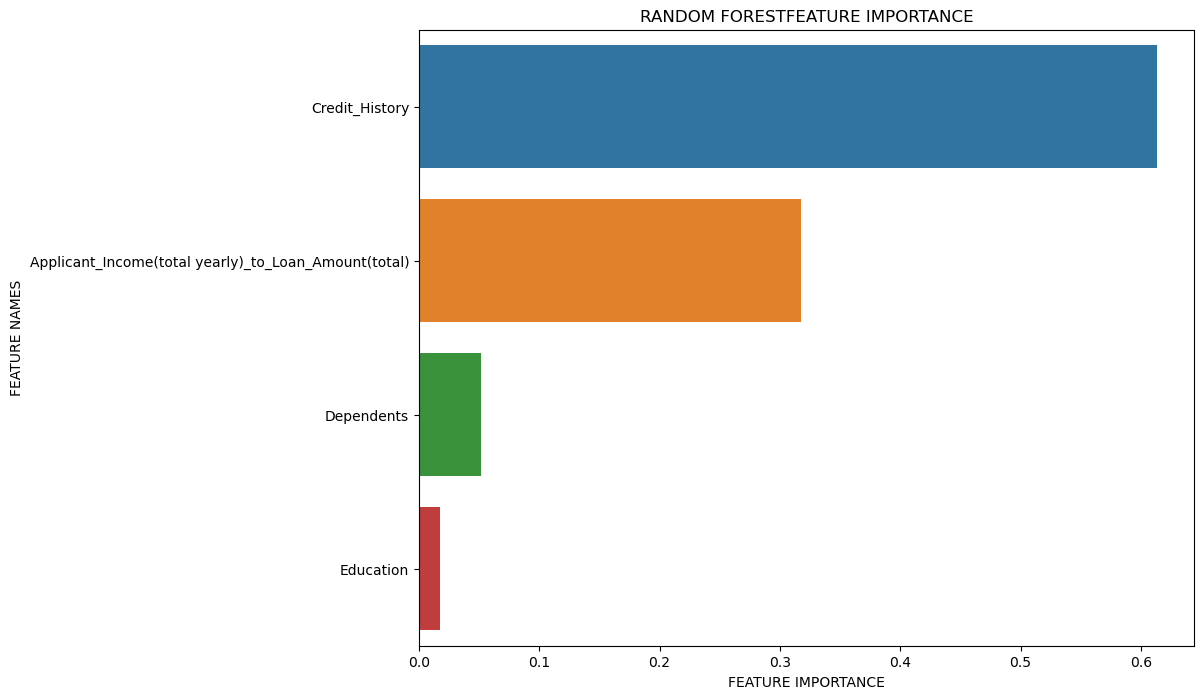

In [72]:
X = df[features]
Y = df['Loan_Status']
model = RandomForestClassifier(n_estimators=256, max_depth = 5, max_features = .5)
model.fit(X,Y)

plot_feature_importance(model.feature_importances_,features,'RANDOM FOREST')

Exact explainer: 574it [00:35, 12.94it/s]                                                                              


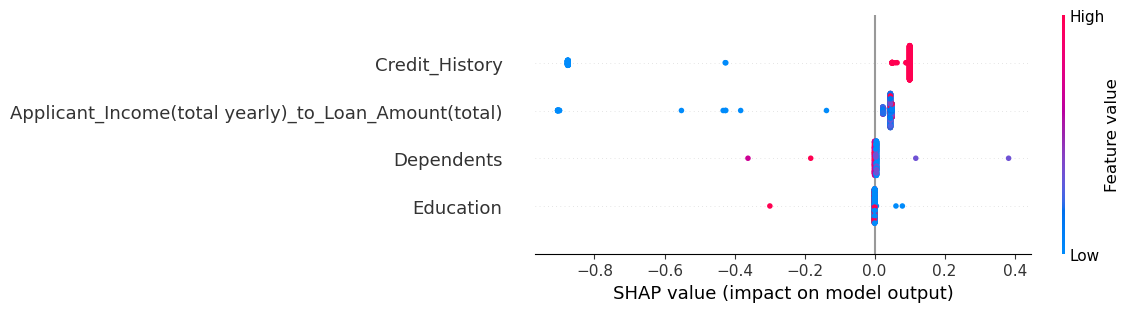

In [76]:
y_train =test_train_RF_Classifier_Hyperparameter[0]['Loan_Status']
model = RandomForestClassifier(n_estimators=256, max_depth = 5, max_features = .5).fit(X_train,y_train)

#Get shap values
explainer = shap.Explainer(model.predict, X_train)
X_sample = df[features]
shap_values = explainer(X_sample)

# Beeswarm plot
shap.plots.beeswarm(shap_values)

Our feature importance and shap graphs clearly outline credit_history has the biggest impact on loan_status, followed by total income to loan amount ratio.

We see that higher credit history (indicating there is a credit history) impact in a higher model output, where 1 is 'eligible'.

For the total income to loan amount ratio, we also note if this value is higher then model output is higher. Note the feature value for this ratio is less than credit_history.

Dependents and Education certainly do have impact, but the SHAP value is low, indicating less influence.

As it relates to our initial hypothesis of: 'People who are most eligible for home loans have a credit history, education, an employer that is not themselves, and a coapplicant,' it is certainly clear that we were correct about history and in the end that education does have an impact. However, it turns out employer type and presence of coapplicant are not the best predictors for loan status. There was an instinct to create the total income to loan amount ratio, but it's influence in loan status was not expected based on our hypothesis.

## 6) Run test.csv through model
Now, we will clean the test.csv and run our model to see who it predicts in the 'eligible' cateogory!

### 6a) Import test data

In [23]:
# import csv
test_df = pd.read_csv('../data/test.csv')

### 6b) Clean test data

In [26]:
# clean test data with our function from EDA notebook

# create function to drop any rows with nulls values for features where the number of null values is <3% of the total rows in our data
def drop_nas(df):
    for feature in df.columns:
        null_sum = df[feature].isnull().sum()
        if null_sum < len(df) * .03 and null_sum != 0:
            df.dropna(subset = [feature], inplace = True)
    return df

# create function to encode object values using label_encoder
# leave null values for now until we impute their values
def column_encoder(data):
    # initiate and define label_encoder
    label_encoder = preprocessing.LabelEncoder()
    # user label_encoder on features of interest
    data['Gender'].loc[data['Gender'].notnull()] = label_encoder.fit_transform(data['Gender'].loc[data['Gender'].notnull()])
    data['Married'].loc[data['Married'].notnull()] = label_encoder.fit_transform(data['Married'].loc[data['Married'].notnull()])
    data['Dependents'].loc[data['Dependents'].notnull()] = label_encoder.fit_transform(data['Dependents'].loc[data['Dependents'].notnull()])
    data['Education'].loc[data['Education'].notnull()] = label_encoder.fit_transform(data['Education'].loc[data['Education'].notnull()])   
    data['Self_Employed'].loc[data['Self_Employed'].notnull()] = label_encoder.fit_transform(data['Self_Employed'].loc[data['Self_Employed'].notnull()])
    data['Property_Area'].loc[data['Property_Area'].notnull()] = label_encoder.fit_transform(data['Property_Area'].loc[data['Property_Area'].notnull()])
    return data

# create column denoting if there is a coapplicant through values 0 = N and 1 = Y
def coapplicant(data,column):         
    Coapplicant = []
    for i in data[column]:
        if i == 0:
            Coapplicant.append(0)
        else:
            Coapplicant.append(1)
    data['Coapplicant'] = Coapplicant
    return data

# create function to clean data to match process from train.csv EDA
# this function assumes we have checked that the test data has the same columns as our train
def clean_test(df):
    test_clean_df = df.copy()
    test_clean_df.drop(columns=['Loan_ID'], inplace=True)
    
    # call drop_nas
    drop_nas(test_clean_df)
    
    # call column_encoder
    column_encoder(test_clean_df)
    
    # dtypes are still objects from column_encoder, change to int
    columns = ['Gender','Married','Dependents','Education','Self_Employed','Property_Area']
    test_clean_df[columns] = test_clean_df[columns].apply(pd.to_numeric, errors='coerce')
    
    # impute Self_Employed nulls to mode if applicable
    self_employed_mode = test_clean_df['Self_Employed'].mode()
    test_clean_df['Self_Employed'].fillna(value=self_employed_mode.values[0],inplace=True)
    
    # impute Credit_History nulls to mode if applicable
    credit_history_mode = test_clean_df['Credit_History'].mode()
    test_clean_df['Credit_History'].fillna(value=credit_history_mode.values[0],inplace=True)
    
    # impute LoanAmount nulls to median if applicable
    loan_amount_median = test_clean_df['LoanAmount'].median()
    test_clean_df['LoanAmount'].fillna(value=loan_amount_median,inplace=True)
    
    # rename loan term column to include it's measurement - months
    test_clean_df.rename(columns = {'Loan_Amount_Term':'Loan_Amount_Term_Months'}, inplace = True)
    
    # new variable for applicant total income / loan amount
    # create new value for applicant income to loan amount
    test_clean_df['Applicant_Income(total yearly)_to_Loan_Amount(total)'] = (((test_clean_df['ApplicantIncome']*12) + (test_clean_df['CoapplicantIncome']*12)) / (test_clean_df['LoanAmount']*1000))
    
    # call coapplicant
    coapplicant(test_clean_df,'CoapplicantIncome')
    
    # remove unecessary columns that are now represented in the two columns we just created
    # drop ApplicantIncome_Monthly and LoanAmount_Thousands from df
    test_clean_df.drop(columns = ['ApplicantIncome','CoapplicantIncome','LoanAmount'],inplace = True)
    
    # other cleaning outside of EDA notebook activity to ensure values are valid
    # check that Gender, Married, Education, Self Employed values are 0 or 1
    columns = ['Gender','Married','Education','Self_Employed']
    for feature in columns:
        for i in test_clean_df[feature]:
            test_clean_df.drop(test_clean_df.loc[(test_clean_df[feature] < 0) | (test_clean_df[feature] > 1)].index, inplace=True)
     
    # drop values for Dependents outside of 0-3
    test_clean_df.drop(test_clean_df.loc[(test_clean_df['Dependents'] < 0) | (test_clean_df['Dependents'] > 3)].index, inplace=True)
    
    # drop values for Property_Area outside 0-2
    test_clean_df.drop(test_clean_df.loc[(test_clean_df['Property_Area'] < 0) | (test_clean_df['Property_Area'] > 2)].index, inplace=True)
    
    # drop Loan_Amount_Term < 0 and > 480 (40 years)
    test_clean_df.drop(test_clean_df.loc[(test_clean_df['Loan_Amount_Term_Months'] < 0) | (test_clean_df['Loan_Amount_Term_Months'] > 480)].index, inplace=True)
    
    # drop income / loan amount ratio < 0
    test_clean_df.drop(test_clean_df.loc[test_clean_df['Applicant_Income(total yearly)_to_Loan_Amount(total)'] < 0].index, inplace=True)
    
    return test_clean_df

In [29]:
df_test_clean = clean_test(test_df)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

In [30]:
# view results
df_test_clean

Gender  Married  Dependents  Education  Self_Employed  \
0         1        1           0          0            0.0   
1         1        1           1          0            0.0   
2         1        1           2          0            0.0   
3         1        1           2          0            0.0   
4         1        0           0          1            0.0   
..      ...      ...         ...        ...            ...   
362       1        1           3          1            1.0   
363       1        1           0          0            0.0   
364       1        0           0          0            0.0   
365       1        1           0          0            0.0   
366       1        0           0          0            1.0   

     Loan_Amount_Term_Months  Credit_History  Property_Area  \
0                      360.0             1.0              2   
1                      360.0             1.0              2   
2                      360.0             1.0              2   
3                      360.0             1.0              2   
4                      360.0             1.0              2   
..                       ...             ...            ...   
362                    360.0             1.0              2   
363                    360.0             1.0              2   
364                    360.0             1.0              1   
365                    360.0             1.0              0   
366                    180.0             1.0              0   

     Applicant_Income(total yearly)_to_Loan_Amount(total)  Coapplicant  
0                                             0.624000               0  
1                                             0.435810               1  
2                                             0.392308               1  
3                                             0.586320               1  
4                                             0.504000               0  
..                                                 ...             ...  
362                                           0.614442               1  
363                                           0.507861               1  
364                                           0.499333               1  
365                                           0.561494               1  
366                                           1.126531               0  

[337 rows x 10 columns]

Our cleaning took off 30 rows of data.

### 6c) run clean test data through our top performing model

In [38]:
# use features from top performing model
# select features from top performing model
features = ['Credit_History', 'Applicant_Income(total yearly)_to_Loan_Amount(total)', 'Dependents','Education']

# get test/train data
train_data = df
train_data_x = df[features]
train_data_y = df['Loan_Status']
test_data = df_test_clean[features]

# train model
model = RandomForestClassifier(n_estimators=256, max_depth = 5, max_features = .5)
model.fit(train_data_x, train_data_y)

# validate model
test_results = model.predict(test_data)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [44]:
# print test results
test_results

array([1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1,
       1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0,
       1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1,
       1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1,